In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import os

In [2]:

carpeta_pm25 = "Datasets\Datos_SIATA_Aire_pm25.json"

with open(carpeta_pm25, "r", encoding="utf-8") as f:data = json.load(f)

registros = []

        
for estacion in data:
    lat = estacion.get("latitud")
    lon = estacion.get("longitud")
    codigo = estacion.get("codigoSerial")
    nombre = estacion.get("nombre")
    nombreCorto = estacion.get("nombreCorto")
    datos = estacion.get("datos", [])

    for entrada in datos:
        registros.append({
            "codigoSerial": codigo,
            "nombre": nombre,
            "nombreCorto": nombreCorto,
            "latitud": lat,
            "longitud": lon,
            "contaminante": entrada.get("variableConsulta"),
            "fecha": entrada.get("fecha"),
            "calibracion": entrada.get("valor"), # Ojooo esto es calibración 
            "valor": entrada.get("calidad") # Y esto calidad, osea que la calidad se llama valor y la calibración valga la redundancia calibración 
        })

# Convertimos a DataFrame como antes
df = pd.DataFrame(registros)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df["calibracion"] = pd.to_numeric(df["calibracion"], errors='coerce')


df.loc[df["calibracion"] == -9999, 'valor'] = np.nan

print(df.head(20))


    codigoSerial                               nombre nombreCorto   latitud  \
0              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
1              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
2              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
3              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
4              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
5              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
6              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
7              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
8              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
9              3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
10             3  _OFF-Girardota - S.O.S Aburrá Norte    GIR-SOSN  6.378433   
11             3  _OFF-Girardota - S.O.S Aburrá Nort

In [3]:
validos_por_estacion = df.groupby('nombreCorto')['valor'].apply(lambda x: x.notna().mean() * 100)
validos_por_contaminante = df.groupby('contaminante')['valor'].apply(lambda x: x.notna().mean() * 100)
print(f"Porcentaje datos válidos por estación\n{validos_por_estacion}\n\nPorcentaje datos válidos por contaminante{validos_por_contaminante}")

Porcentaje datos válidos por estación
nombreCorto
BAR-TORR    98.322109
BEL-FEVE    99.086862
CAL-JOAR    97.694327
CAL-LASA    57.607579
CEN-TRAF    98.641708
COP-CVID    99.520603
ENV-HOSP    99.337975
EST-HOSP    97.865540
GIR-SOSN     0.022828
ITA-CJUS    99.269490
ITA-CONC    98.915649
MED-ALTA    99.143933
MED-ARAN    99.292318
MED-BEME    99.109691
MED-LAYE    99.611916
MED-SCRI    98.230796
MED-TESO    98.881406
MED-UNNV     0.000000
MED-VILL    99.532017
SAB-RAME    98.459080
SUR-TRAF    97.808469
Name: valor, dtype: float64

Porcentaje datos válidos por contaminantecontaminante
pm25    87.445443
Name: valor, dtype: float64


In [4]:
# Obtener contaminante único (ya que el archivo es solo de uno)
contaminante_unico = df['contaminante'].unique()[0] if not df['contaminante'].isna().all() else "Desconocido"



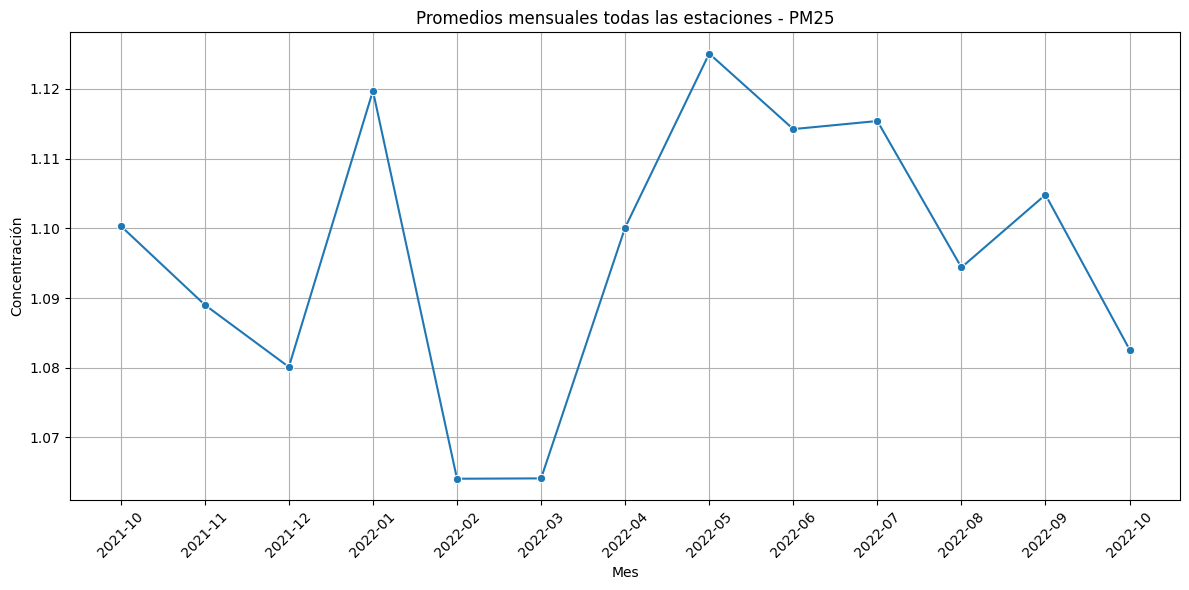

In [5]:
df['mes'] = df['fecha'].dt.to_period("M")
promedios_mensuales = df.groupby('mes')['valor'].mean().reset_index()
promedios_mensuales['mes'] = promedios_mensuales['mes'].astype(str)

# Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=promedios_mensuales, x='mes', y='valor', marker='o')
plt.title(f'Promedios mensuales todas las estaciones - {contaminante_unico.upper()}')
plt.xlabel('Mes')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# 5. Mapa estático de estaciones segun datos validos



# Media por estacion
media_estaciones = df.groupby(['codigoSerial', 'nombre', 'latitud', 'longitud'])['valor'].mean().reset_index()

validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)

media_estaciones['porcentaje_validos'] = media_estaciones['codigoSerial'].map(validos_por_estacion)


mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)

for _, row in media_estaciones.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=6,
        popup=(
            f"Estación {row['nombre']}\n"
            f"Media: {row['valor']:.2f}\n"
            f"Válidos: {row['porcentaje_validos']:.1f}%"
        ),
        color = 'green' if row['porcentaje_validos'] >= 51 else 'red',
        fill=True,
    ).add_to(mapa)

mapa

In [7]:
# mapa por estacion según concentracion de la partícula

media_estaciones = df.groupby(['codigoSerial', 'nombre', 'latitud', 'longitud'])['valor'].mean().reset_index()

# Porcentaje de datos válidos por estación
validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)
media_estaciones['porcentaje_validos'] = media_estaciones['codigoSerial'].map(validos_por_estacion)

# Clasificación de color según niveles de concentración promedio
def clasificar_calidad_aire(valor, contaminante):
    if pd.isna(valor):
        return "Sin datos"
    
    contaminante = contaminante.lower()
    
    if contaminante == 'pm25':
        if valor <= 12:
            return "Bueno"
        elif valor <= 35.4:
            return "Aceptable"
        elif valor <= 55.4:
            return "No saludable sensibles"
        elif valor <= 150.4:
            return "No saludable"
        elif valor <= 250.4:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'pm10':
        if valor <= 54:
            return "Bueno"
        elif valor <= 154:
            return "Aceptable"
        elif valor <= 254:
            return "No saludable sensibles"
        elif valor <= 354:
            return "No saludable"
        elif valor <= 424:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'co':
        if valor <= 4.4:
            return "Bueno"
        elif valor <= 9.4:
            return "Aceptable"
        elif valor <= 12.4:
            return "No saludable sensibles"
        elif valor <= 15.4:
            return "No saludable"
        elif valor <= 30.4:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'ozono':
        if valor <= 0.054:
            return "Bueno"
        elif valor <= 0.070:
            return "Aceptable"
        elif valor <= 0.085:
            return "No saludable sensibles"
        elif valor <= 0.105:
            return "No saludable"
        elif valor <= 0.200:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'no2':
        if valor <= 0.053:
            return "Bueno"
        elif valor <= 0.100:
            return "Aceptable"
        elif valor <= 0.360:
            return "No saludable sensibles"
        elif valor <= 0.649:
            return "No saludable"
        elif valor <= 1.249:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'so2':
        if valor <= 0.035:
            return "Bueno"
        elif valor <= 0.075:
            return "Aceptable"
        elif valor <= 0.185:
            return "No saludable sensibles"
        elif valor <= 0.304:
            return "No saludable"
        elif valor <= 0.604:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'no' or contaminante == 'pm1':
        return "Sin estándar oficial"

    else:
        return "Contaminante desconocido"
    
def color_por_categoria(categoria):
    colores = {
        "Bueno": "green",
        "Aceptable": "yellow",
        "No saludable sensibles": "orange",
        "No saludable": "red",
        "Muy no saludable": "purple",
        "Peligroso": "maroon",
        "Sin datos": "gray",
        "Sin estándar oficial": "blue",
        "Contaminante desconocido": "black"
    }
    return colores.get(categoria, "black")


# Crear mapa
mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)

for _, row in media_estaciones.iterrows():
    categoria = clasificar_calidad_aire(row['valor'], contaminante_unico) 
    color = color_por_categoria(categoria)
    radio = 4 + (row['valor'] / 5) if not pd.isna(row['valor']) else 4
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=radio,
        popup=folium.Popup(
            f"<b>{row['nombre']}</b><br>"
            f"Media: {row['valor']:.2f}<br>"
            f"Categoría: {categoria}<br>"
            f"Válidos: {row['porcentaje_validos']:.1f}%",
            max_width=300
        ),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(mapa)

# Mostrar mapa en notebook
mapa

In [8]:
df['dia_semana'] = df['fecha'].dt.weekday  # Lunes=0, Domingo=6
df['es_fin_semana'] = df['dia_semana'] >= 5

In [9]:
eventos_especiales = {
    '2021-12-24': 'Navidad',
    '2021-12-31': 'Año Nuevo',
    '2022-01-06': 'Día de Reyes',
    '2022-04-10': 'Semana Santa',
    '2022-04-15': 'Semana Santa',
    '2022-07-20': 'Independencia',
    '2022-08-07': 'Feria de las Flores',
    '2022-08-08': 'Feria de las Flores',
    '2022-09-22': 'Día sin carro',
    '2022-10-31': 'Halloween',
    '2022-12-07': 'Día de las Velitas',
    '2022-12-24': 'Navidad',
    '2022-12-31': 'Año Nuevo',
    # Puedes seguir agregando...
}


In [10]:
df['fecha_str'] = df['fecha'].dt.strftime('%Y-%m-%d')
df['evento'] = df['fecha_str'].map(eventos_especiales).fillna("Normal")
df

,codigoSerial,nombre,nombreCorto,latitud,longitud,contaminante,fecha,calibracion,valor,mes,dia_semana,es_fin_semana,fecha_str,evento
0,3,_OFF-Girardota - S.O.S Aburrá Norte,GIR-SOSN,6.378433,-75.451141,pm25,2021-10-12 04:00:00,-9999.0000,NaN,2021-10,1,False,2021-10-12,Normal
1,3,_OFF-Girardota - S.O.S Aburrá Norte,GIR-SOSN,6.378433,-75.451141,pm25,2021-10-12 05:00:00,-9999.0000,NaN,2021-10,1,False,2021-10-12,Normal
2,3,_OFF-Girardota - S.O.S Aburrá Norte,GIR-SOSN,6.378433,-75.451141,pm25,2021-10-12 06:00:00,-9999.0000,NaN,2021-10,1,False,2021-10-12,Normal
3,3,_OFF-Girardota - S.O.S Aburrá Norte,GIR-SOSN,6.378433,-75.451141,pm25,2021-10-12 07:00:00,-9999.0000,NaN,2021-10,1,False,2021-10-12,Normal
4,3,_OFF-Girardota - S.O.S Aburrá Norte,GIR-SOSN,6.378433,-75.451141,pm25,2021-10-12 08:00:00,-9999.0000,NaN,2021-10,1,False,2021-10-12,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183976,90,Sabaneta - I.E. Rafael J. Mejía,SAB-RAME,6.145500,-75.621262,pm25,2022-10-12 00:00:00,18.9537,1.0,2022-10,2,False,2022-10-12,Normal
183977,90,Sabaneta - I.E. Rafael J. Mejía,SAB-RAME,6.145500,-75.621262,pm25,2022-10-12 01:00:00,15.3660,1.0,2022-10,2,False,2022-10-12,Normal
183978,90,Sabaneta - I.E. Rafael J. Mejía,SAB-RAME,6.145500,-75.621262,pm25,2022-10-12 02:00:00,15.3597,1.0,2022-10,2,False,2022-10-12,Normal
183979,90,Sabaneta - I.E. Rafael J. Mejía,SAB-RAME,6.145500,-75.621262,pm25,2022-10-12 03:00:00,18.9207,1.0,2022-10,2,False,2022-10-12,Normal


Datos muy importantes 

In [11]:
#Semana vs fin de semana

promedios_dia = df.groupby('es_fin_semana')['valor'].mean()
print(promedios_dia)


es_fin_semana
False    1.099152
True     1.091629
Name: valor, dtype: float64


In [12]:
#fechas especiales vs fechas normales

promedios_evento = df.groupby('evento')['valor'].mean()
print(promedios_evento)


evento
Año Nuevo              1.033560
Día de Reyes           1.036996
Día sin carro          1.071226
Feria de las Flores    1.187633
Independencia          1.153774
Navidad                1.017325
Normal                 1.097320
Semana Santa           1.042880
Name: valor, dtype: float64


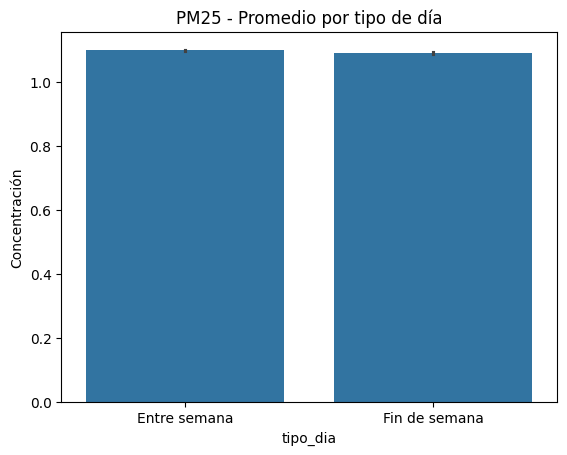

In [13]:
df['dia_semana'] = df['fecha'].dt.weekday
df['tipo_dia'] = df['dia_semana'].apply(lambda x: 'Fin de semana' if x >= 5 else 'Entre semana')

sns.barplot(data=df, x='tipo_dia', y='valor')
plt.title(f'{contaminante_unico.upper()} - Promedio por tipo de día')
plt.ylabel('Concentración')
plt.show()
#Semana vs fin de semana

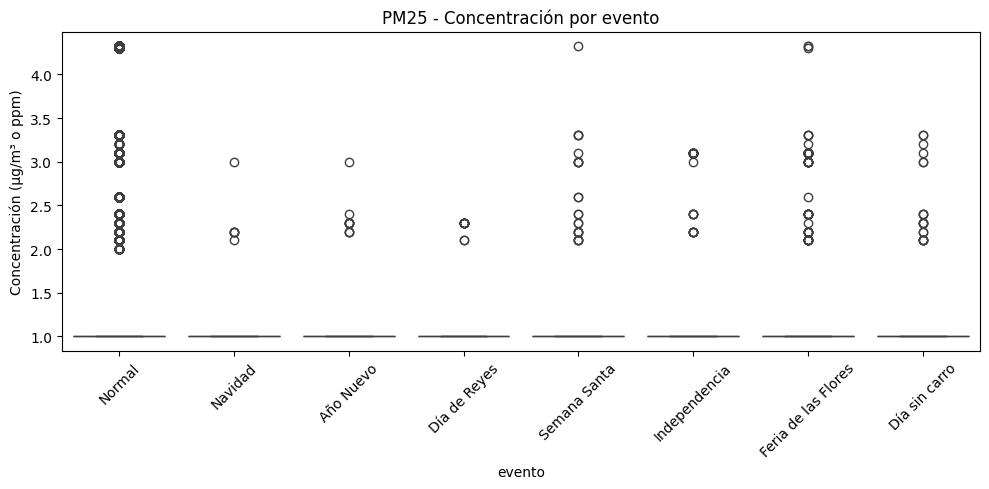

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='evento', y='valor')
plt.title(f'{contaminante_unico.upper()} - Concentración por evento')
plt.ylabel('Concentración (μg/m³ o ppm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#fechas especiales vs fechas normales

In [15]:
resumen = df.groupby(['tipo_dia', 'evento'])['valor'].mean().unstack()
resumen


evento,Año Nuevo,Día de Reyes,Día sin carro,Feria de las Flores,Independencia,Navidad,Normal,Semana Santa
tipo_dia,,,,,,,,
Entre semana,1.03356,1.036996,1.071226,1.197491,1.153774,1.017325,1.099711,1.050609
Fin de semana,NaN,NaN,NaN,1.177958,NaN,NaN,1.091361,1.035202


In [16]:
#estaciones con peor aire

media_top = media_estaciones[['nombre', 'valor']].sort_values(by='valor', ascending=False)
print(media_top.head(10))


                                               nombre     valor
12                             Barbosa - Torre Social  1.166724
7                                Estación Tráfico Sur  1.144280
16  Medellín, San Cristobal - Parque Biblioteca Fe...  1.127353
20                    Sabaneta - I.E. Rafael J. Mejía  1.113367
4   _OFF-Caldas - Corporacion Universitaria Lasall...  1.104212
11  Medellín, Villahermosa - Planta de producción ...  1.102195
10     Medellín, Altavista - I.E. Pedro Octavio Amado  1.095646
1                             Estación Tráfico Centro  1.092011
8                    Caldas - E U Joaquín Aristizabal  1.089749
3                    Itagüí - Casa de Justicia Itagüí  1.089087


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_19864\3759753072.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=estaciones_ordenadas, x='valor', y='nombre', palette='Spectral')


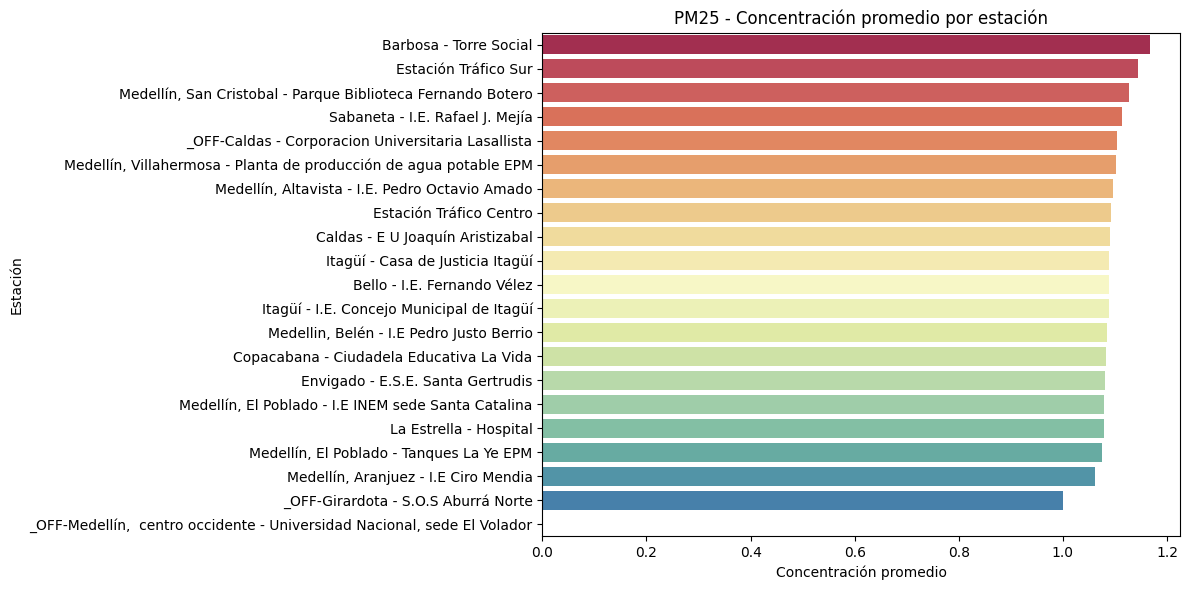

In [17]:
plt.figure(figsize=(12, 6))
estaciones_ordenadas = media_estaciones.sort_values(by='valor', ascending=False)
sns.barplot(data=estaciones_ordenadas, x='valor', y='nombre', palette='Spectral')
plt.title(f'{contaminante_unico.upper()} - Concentración promedio por estación')
plt.xlabel('Concentración promedio')
plt.ylabel('Estación')
plt.tight_layout()
plt.show()


In [18]:
media_plot = media_estaciones.dropna(subset=['valor'])


import plotly.express as px

fig = px.scatter_mapbox(
    media_plot,
    lat="latitud", lon="longitud",
    color="valor",
    size="valor",
    hover_name="nombre",
    color_continuous_scale="YlOrRd",
    size_max=15,
    zoom=10,
    mapbox_style="carto-positron"
)
fig.update_layout(title=f'{contaminante_unico.upper()} - Concentración por estación')
fig.show()


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_19864\2607126680.py:6: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


In [19]:
limites_normativos = {
    'pm25': 25,   # μg/m³ (24h) - OMS
    'pm10': 50,   # μg/m³ (24h) - OMS
    'ozono': 0.051,  # ppm (8h) - OMS 100 μg/m³ → 0.051 ppm aprox
    'co': 4.0,    # ppm (24h) - OMS
    'no2': 0.025, # ppm (1h) - OMS
    'so2': 0.005, # ppm (24h) - OMS
    # otros...
}


In [20]:
contaminante = contaminante_unico.lower()
limite = limites_normativos.get(contaminante, None)

if limite:
    df['excede_limite'] = df['valor'] > limite
    excedencias = df['excede_limite'].mean() * 100
    print(f"📌 Porcentaje de registros que exceden el límite OMS para {contaminante.upper()}: {excedencias:.2f}%")
else:
    print("No hay límite definido para este contaminante.")


📌 Porcentaje de registros que exceden el límite OMS para PM25: 0.00%


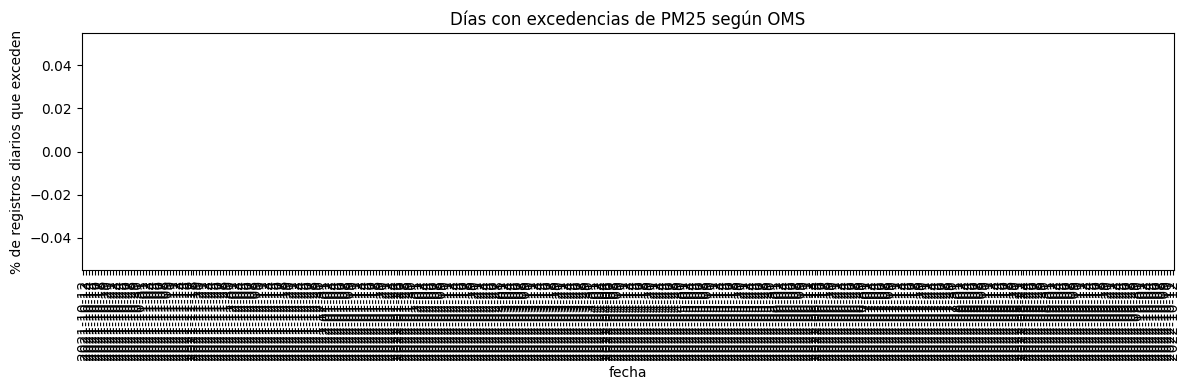

In [21]:
#gafico de dias que exceden

excesos_diarios = df.groupby(df['fecha'].dt.date)['excede_limite'].mean()

plt.figure(figsize=(12, 4))
excesos_diarios.plot(kind='bar', color='red')
plt.title(f'Días con excedencias de {contaminante.upper()} según OMS')
plt.ylabel('% de registros diarios que exceden')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


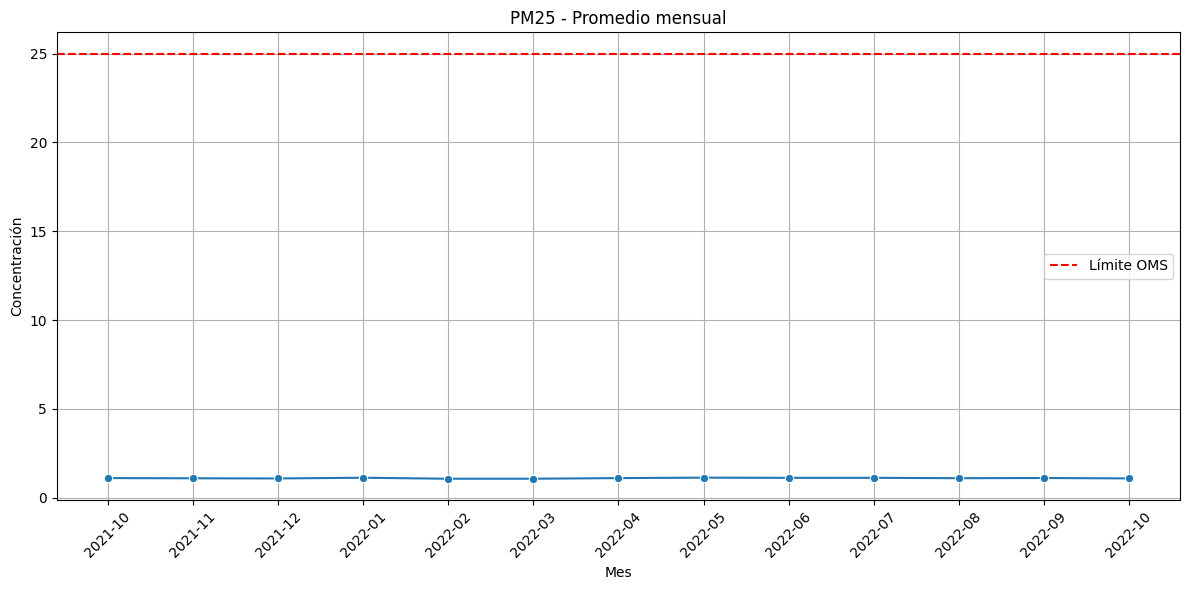

In [22]:
#comparar promedios mensuales con los limites
plt.figure(figsize=(12,6))
sns.lineplot(data=promedios_mensuales, x='mes', y='valor', marker='o')
if limite:
    plt.axhline(y=limite, color='red', linestyle='--', label='Límite OMS')
plt.title(f'{contaminante_unico.upper()} - Promedio mensual')
plt.xlabel('Mes')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


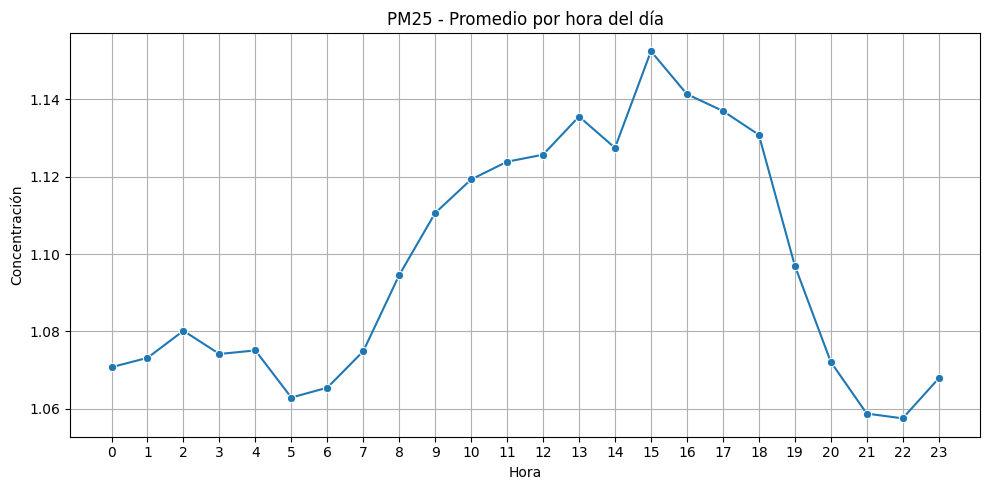

In [23]:
#variacion por hora del dia
df['hora'] = df['fecha'].dt.hour

horas = df.groupby('hora')['valor'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=horas, x='hora', y='valor', marker='o')
plt.title(f'{contaminante_unico.upper()} - Promedio por hora del día')
plt.xlabel('Hora')
plt.ylabel('Concentración')
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
#Top 10 dias mas contaminados
top_dias = df.groupby(df['fecha'].dt.date)['valor'].mean().sort_values(ascending=False).head(10)
print("Días con mayor concentración promedio:")
print(top_dias)


Días con mayor concentración promedio:
fecha
2021-12-18    1.359430
2022-04-26    1.332037
2022-09-18    1.277049
2022-09-24    1.253608
2022-01-19    1.235131
2022-05-27    1.230557
2022-07-30    1.223657
2022-04-27    1.220257
2021-11-20    1.215239
2022-01-10    1.210263
Name: valor, dtype: float64


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_19864\951271130.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




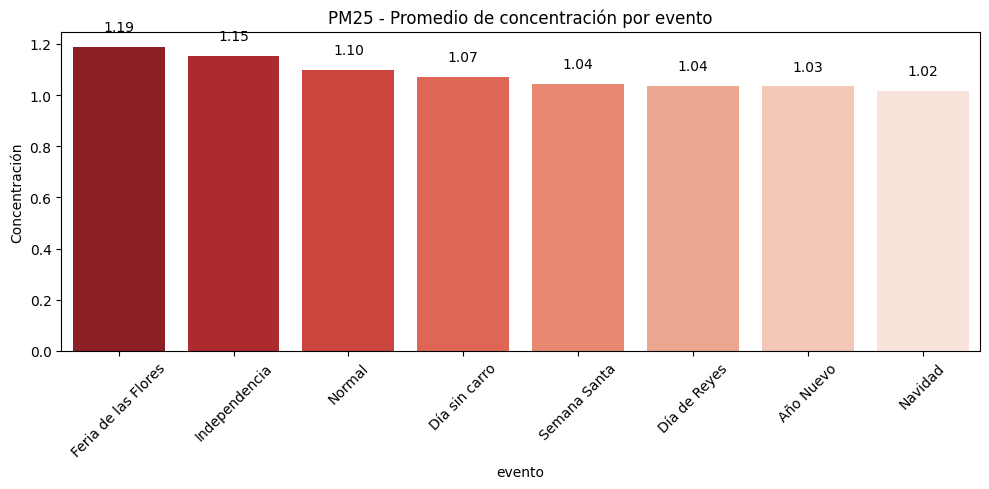

In [25]:
promedio_eventos = df.groupby('evento')['valor'].mean().sort_values(ascending=False)

# Convertir a DataFrame y ordenar por valor (descendente)
evento_df = promedio_eventos.reset_index()
evento_df.columns = ['evento', 'valor']
evento_df = evento_df.sort_values(by='valor', ascending=False).reset_index(drop=True)

# Crear una paleta personalizada basada en el número de eventos
paleta = sns.color_palette("Reds", n_colors=len(evento_df))

# Graficar
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=evento_df,
    x='evento', y='valor',
    palette=paleta[::-1]  # ahora sí, inverso en orden decreciente
)

# Agregar etiquetas
for i, val in enumerate(evento_df['valor']):
    ax.text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom')

plt.title(f'{contaminante_unico.upper()} - Promedio de concentración por evento')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
stats_eventos = df.groupby('evento')['valor'].agg(['count', 'mean', 'std', 'min', 'max']).sort_values(by='mean', ascending=False)
print(stats_eventos)


                      count      mean       std  min   max
evento                                                    
Feria de las Flores     854  1.187633  0.579919  1.0  4.32
Independencia           424  1.153774  0.524334  1.0  3.10
Normal               156949  1.097320  0.427763  1.0  4.32
Día sin carro           424  1.071226  0.334215  1.0  3.30
Semana Santa            889  1.042880  0.278121  1.0  4.32
Día de Reyes            446  1.036996  0.214107  1.0  2.30
Año Nuevo               441  1.033560  0.212792  1.0  3.00
Navidad                 456  1.017325  0.154302  1.0  3.00


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_19864\1442359101.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




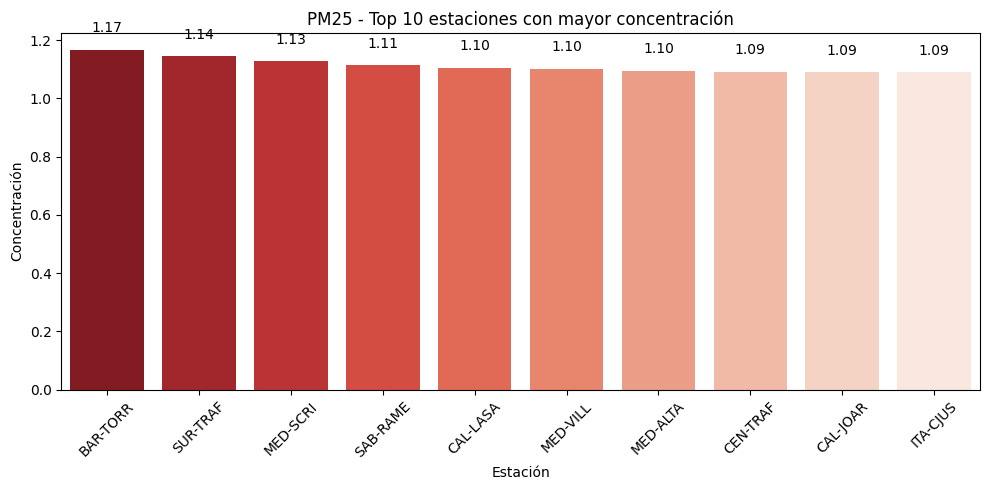

In [27]:
# Promedio por estación
top_estaciones = df.groupby('nombreCorto')['valor'].mean().sort_values(ascending=False).head(10).reset_index()

# Paleta de colores (más alta concentración = más oscuro)
paleta = sns.color_palette("Reds", n_colors=len(top_estaciones))

# Gráfico
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=top_estaciones,
    x='nombreCorto', y='valor',
    palette=paleta[::-1]
)

# Etiquetas
for i, val in enumerate(top_estaciones['valor']):
    ax.text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom')

plt.title(f'{contaminante_unico.upper()} - Top 10 estaciones con mayor concentración')
plt.ylabel('Concentración')
plt.xlabel('Estación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


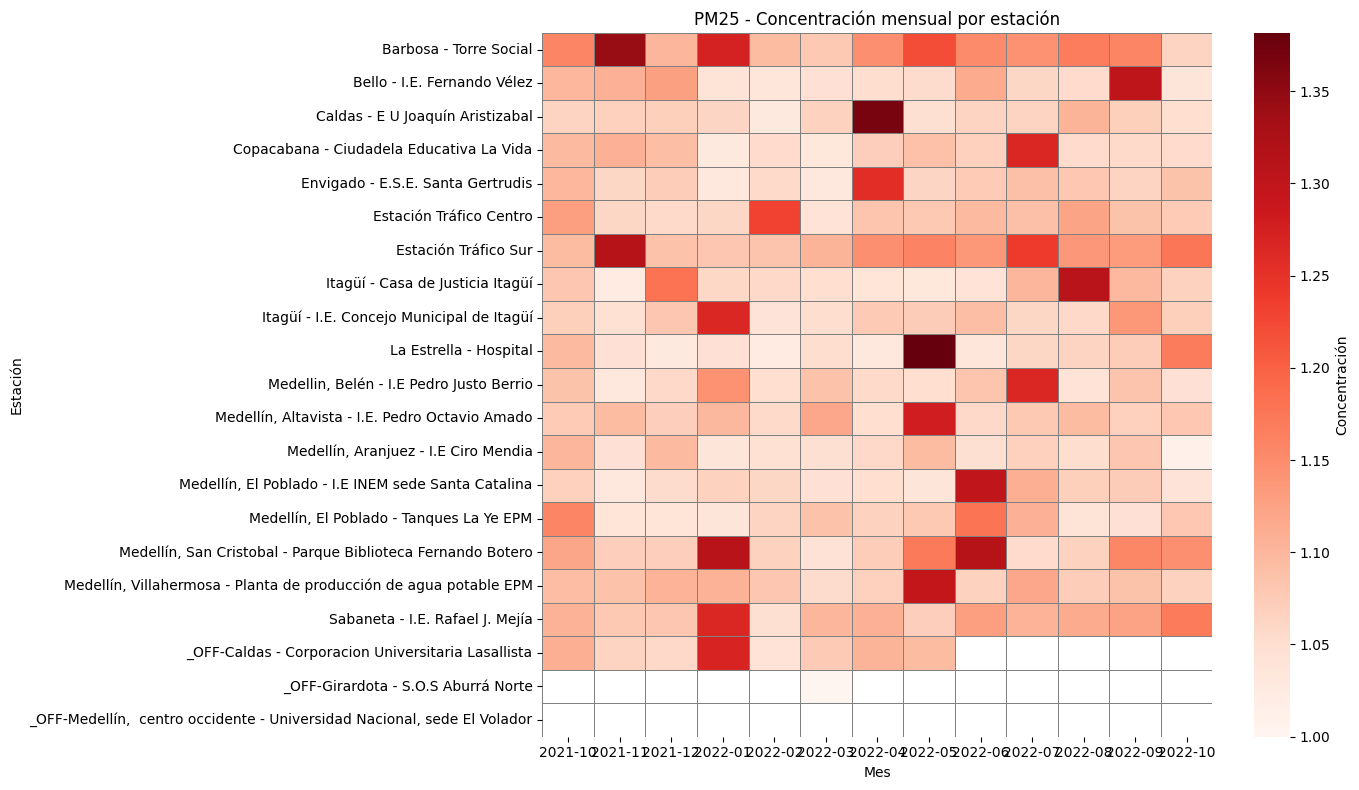

In [28]:
# Crear columna de mes
df['mes'] = df['fecha'].dt.to_period('M').astype(str)

# Agrupamos por estación y mes
pivot_df = df.groupby(['nombre', 'mes'])['valor'].mean().reset_index()

# Reorganizar en forma de matriz
pivot_table = pivot_df.pivot(index='nombre', columns='mes', values='valor')

# Crear heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap="Reds", linewidths=0.5, linecolor='gray', annot=False, fmt=".1f", cbar_kws={'label': 'Concentración'})
plt.title(f'{contaminante_unico.upper()} - Concentración mensual por estación')
plt.xlabel('Mes')
plt.ylabel('Estación')
plt.tight_layout()
plt.show()


In [29]:
import plotly.express as px

# Asegurar que el mes esté como string
df['mes'] = df['fecha'].dt.to_period("M").astype(str)

# Calcular promedio mensual por estación
mapa_mensual = df.groupby(['nombre', 'latitud', 'longitud', 'mes'])['valor'].mean().reset_index()

media_mensual_limpio = mapa_mensual.dropna(subset=['valor'])

# Crear mapa animado
fig = px.scatter_mapbox(
    media_mensual_limpio,
    lat="latitud", lon="longitud",
    color="valor",
    size="valor",
    animation_frame="mes",
    hover_name="nombre",
    color_continuous_scale="Reds",
    size_max=15,
    zoom=10,
    mapbox_style="carto-positron",
    title=f'{contaminante_unico.upper()} - Concentración mensual por estación'
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_19864\3309211999.py:12: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

